# Pre-process the data #

Pre-requisites to using this file
- Run the string_preprocessing.py main function and store the STRING database with known interactions as ../data_processed/STRING_full_filtered.tsv
- Manually retrieve STRING IDs to UniProtIDs and UniProtIDs to GeneIDs

In [1]:
import os
import pandas as pd
from collections import defaultdict
from preprocess_data import *

Preprocess the DNA, RNA, and Protein data


In [2]:
preprocess_dna_data()
preprocess_rna_data()
preprocess_protein_data()

Original shape: (140258, 76)
Transposed shape: (60, 138892)
Original shape: (26188, 66)
Transposed shape: (60, 26178)
Original shape: (3181, 69)
Transposed shape: (59, 3167)


Run the string_preprocessing.py main function before this!

Get all of the STRING IDs from the full filtered STRING and save to a file

In [3]:
known_STRING = pd.read_csv('../data_processed/STRING_full_filtered.tsv', sep='\t')
# Get all STRING IDs in both columns protein1 and protein2
known_STRING_ids = set(known_STRING['protein1']).union(set(known_STRING['protein2']))
# Save all STRING IDs in a file
with open('../data_processed/known_STRING_ids.txt', 'w') as f:
    for id in known_STRING_ids:
        f.write(id + '\n')

print('Number of known STRING IDs: {}'.format(len(known_STRING_ids)))

Number of known STRING IDs: 18727


### Manually get the STRING id to UniProt ID conversion from https://www.uniprot.org/id-mapping/ ###

Manually retrieved STRING IDs to UniProtKB -- 18,305 IDs were mapped to 18,305 results, but 422 ID were not mapped
- Mapped STRING IDs saved at "../data_processed/stringids_to_uniprotkb.tsv"
- Unmapped STRING IDs saved at "../data_processed/STRING_unmapped_stringids.txt"

In [4]:
mapped_uniprot = pd.read_csv('../data_processed/stringids_to_uniprotkb.tsv', sep='\t')
# Get all UniProtKB IDs in "Entry" column
mapped_uniprot_ids = set(mapped_uniprot['Entry'])
# Save all UniProtKB IDs in a file
with open('../data_processed/STRING_mapped_uniprot_ids.txt', 'w') as f:
    for id in mapped_uniprot_ids:
        f.write(id + '\n')

### Manually get the UniProt ID conversion to GeneID from https://www.uniprot.org/id-mapping/ ###

UniProtKB AC/ID to GeneID -- 17,816 IDs were mapped to 18,018 results, but 489 ID were not mapped
- Mapped UniProtIDs saved at "../data_processed/uniprot_ids_to_gene_id.tsv"
- Unmapped UniProtIDs saved at "../data_processed/STRING_unmapped_uniprotids.txt"

The mapped gene IDs have significant intersection with the DNA/RNA/Protein intersection: found 2638 out of 2667

Find the entrez IDs for the IDs that couldn't be mapped. Go from STRING ID -> Protein Symbol (assume same as gene name) -> Entrez ID

In [5]:
# Get all gene names to entrez IDs possible
gene_names_to_entrez_ids = {}

dna_identifier_gene_name_entrez = pd.read_csv('../data_processed/dnaexome_identifier_gene_name_entrez_id.csv')
# for each gene name in "Gene name (d)" column, if it is not in the dictionary, add it with the entrez ID in "Entrez gene id (e)" column
for index, row in dna_identifier_gene_name_entrez.iterrows():
    gene_name = row['Gene name (d)']
    entrez_id = row['Entrez gene id (e)']
    if gene_name not in gene_names_to_entrez_ids:
        gene_names_to_entrez_ids[gene_name] = entrez_id
    else:
        # Check if the entrez id is the same
        if gene_names_to_entrez_ids[gene_name] != entrez_id:
            print('Error: gene name ' + str(gene_name) + ' has two different entrez IDs: ' + str(gene_names_to_entrez_ids[gene_name]) + ' and ' + str(entrez_id))

rna_gene_name_entrez = pd.read_csv('../data_processed/rna_gene_name_entrez_id.csv')
# for each gene name in "Gene name d" column, if it is not in the dictionary, add it with the entrez ID in "Entrez gene id e" column
for index, row in rna_gene_name_entrez.iterrows():
    gene_name = row['Gene name d']
    entrez_id = row['Entrez gene id e']
    if gene_name not in gene_names_to_entrez_ids:
        gene_names_to_entrez_ids[gene_name] = entrez_id
    else:
        # Check if the entrez id is the same
        if gene_names_to_entrez_ids[gene_name] != entrez_id:
            print('Error: gene name ' + str(gene_name) + ' has two different entrez IDs: ' + str(gene_names_to_entrez_ids[gene_name]) + ' and ' + str(entrez_id))

protein_identifier_gene_name_entrez = pd.read_csv('../data_processed/protein_identifier_gene_name_entrez_id.csv')
# for each gene name in "Gene name d" column, if it is not in the dictionary, add it with the entrez ID in "Entrez gene id e" column
for index, row in protein_identifier_gene_name_entrez.iterrows():
    gene_name = row['Gene name d']
    entrez_id = row['Entrez gene id e']
    if gene_name not in gene_names_to_entrez_ids:
        gene_names_to_entrez_ids[gene_name] = entrez_id
    else:
        # Check if the entrez id is the same
        if gene_names_to_entrez_ids[gene_name] != entrez_id:
            print('Error: gene name ' + str(gene_name) + ' has two different entrez IDs: ' + str(gene_names_to_entrez_ids[gene_name]) + ' and ' + str(entrez_id))

# Print how many gene names are mapped to entrez IDs
print('Number of gene names mapped to entrez IDs: ' + str(len(gene_names_to_entrez_ids)))


Number of gene names mapped to entrez IDs: 27163


- Collect all STRING IDs that could not be mapped to either uniprot or from uniprot to gene id (STRING_unmapped_stringids.txt + STRING_unmapped_uniprot_ids.txt)
- Read in STRING IDs -> protein symbols list
- Convert unmapped STRING IDs -> protein symbols -> entrez_ids
- Keep track of any IDs that still cannot be mapped in a separate list

In [6]:
# Find unmapped STRING IDs -> entrez IDs using protein symbols
unmapped_STRING_ids = set()

with open('../data_processed/STRING_unmapped_stringids.txt', 'r') as f:
    for line in f:
        unmapped_STRING_ids.add(line.strip())
print("No uniprot IDs from string ID: " + str(len(unmapped_STRING_ids)))

unmapped_uniprot_ids = set()
with open('../data_processed/STRING_unmapped_uniprot_ids.txt', 'r') as f:
    for line in f:
        unmapped_uniprot_ids.add(line.strip())
print("No entrez IDs from uniprot: " + str(len(unmapped_uniprot_ids)))

# Get df with mapping from STRING ID to UniProtKB ID
mapped_uniprot = pd.read_csv('../data_processed/stringids_to_uniprotkb.tsv', sep='\t')
for id in unmapped_uniprot_ids:
    string_id = mapped_uniprot[mapped_uniprot['Entry'] == id]['From'].values[0]
    unmapped_STRING_ids.add(string_id)

print("All unmapped STRING IDs: " + str(len(unmapped_STRING_ids)))

stringid_to_protsym = get_protein_id_to_symbol_dict()

# For each unmapped STRING ID, find the corresponding protein symbol, and if it does not exist, add 
# list of string_ids_no_protsym
string_ids_no_protsym = []
mapped_string_ids_to_protsym = {}
for id in unmapped_STRING_ids:
    if id in stringid_to_protsym:
        mapped_string_ids_to_protsym[id] = stringid_to_protsym[id]
    else:
        string_ids_no_protsym.append(id)

print("No protein symbols: " + str(len(string_ids_no_protsym))) # 0
print("Mapped protein symbols: " + str(len(mapped_string_ids_to_protsym.keys()))) # 911


# Map protein symbols to entrez IDs
string_no_entrez = []
string_via_protsym_to_entrez = {}
protsym_derived_entrez = set()
example = 0
for stringid in mapped_string_ids_to_protsym:
    protsym = mapped_string_ids_to_protsym[stringid]
    if protsym in gene_names_to_entrez_ids:
        entrez_id = gene_names_to_entrez_ids[protsym]
        string_via_protsym_to_entrez[stringid] = entrez_id
        protsym_derived_entrez.add(entrez_id)
        if example < 5: # Verified top 5 examples manually
            print(str(stringid) + ' ' + str(protsym) + ' ' + str(entrez_id))
            example += 1
    else:
        string_no_entrez.append(stringid)

print("No entrez for protein symbols: " + str(len(string_no_entrez))) # 390
print("Mapped protein symbols to entrez IDs: " + str(len(string_via_protsym_to_entrez))) # 521

# Save file of string IDs with no entrez ID
with open('../data_processed/STRING_no_entrez.txt', 'w') as f:
    for id in string_no_entrez:
        f.write(id + '\n')


No uniprot IDs from string ID: 422
No entrez IDs from uniprot: 489
All unmapped STRING IDs: 911
No protein symbols: 0
Mapped protein symbols: 911
9606.ENSP00000386807 C4orf48 401115
9606.ENSP00000392147 PPP6C 5537
9606.ENSP00000364791 C6orf48 50854
9606.ENSP00000314500 GALNT14 79623
9606.ENSP00000437957 KIAA2012 100652824
No entrez for protein symbols: 390
Mapped protein symbols to entrez IDs: 521


There are several uniprot IDs that map to multiple entrez IDs, but we can just add all of these to one big list of entrez IDs, store a mapping of the entrez ID to STRING ID

In [7]:
uniprot_mapped_gene = pd.read_csv('../data_processed/uniprot_ids_to_gene_ids.tsv', sep='\t')

# Figure out which uniprot IDs are mapped to multiple gene IDs
uniprot_ids_to_gene_ids = {}
for index, row in uniprot_mapped_gene.iterrows():
    uniprot_id = row['From']
    gene_id = row['To']
    if uniprot_id not in uniprot_ids_to_gene_ids:
        uniprot_ids_to_gene_ids[uniprot_id] = [gene_id]
    else:
        uniprot_ids_to_gene_ids[uniprot_id].append(gene_id)

# Which uniprot IDs are mapped to multiple gene IDs
uniprots_with_multiple_gene_ids = []
for uniprot_id in uniprot_ids_to_gene_ids:
    if len(uniprot_ids_to_gene_ids[uniprot_id]) > 1:
        uniprots_with_multiple_gene_ids.append(uniprot_id)
print('Number of uniprot IDs mapped to multiple gene IDs: ', len(uniprots_with_multiple_gene_ids))
# This is okay because from protein expression or any other data, we don't mind connecting multiple
# entrez IDs to one STRING protein node in the STRING layer

Number of uniprot IDs mapped to multiple gene IDs:  139


Get all STRING IDs to Entrez IDs, create dataframe with columns STRING ID, Protein Symbol, Uniprot ID, Entrez ID, save to file

In [8]:
all_mapped_string_ids_to_entrez = pd.DataFrame(columns=['STRING_ID', 'Protein_Symbol', 'Uniprot_ID', 'Entrez_Gene_ID'])
stringids_no_entrez = []
for stringid in known_STRING_ids:
    protein_symbol = stringid_to_protsym[stringid]
    entrez_id = ''
    uniprot_id = '-'
    if stringid in mapped_uniprot['From'].values:
        # get the row index of where stringid is in the From column
        row_index = mapped_uniprot[mapped_uniprot['From'] == stringid].index[0]
        uniprot_id = mapped_uniprot['Entry'][row_index]
    
    if stringid in string_via_protsym_to_entrez:
        entrez_id = string_via_protsym_to_entrez[stringid]
        new_row_dict = {'STRING_ID': stringid, 'Protein_Symbol': protein_symbol, 'Uniprot_ID': uniprot_id, 'Entrez_Gene_ID': entrez_id}
        all_mapped_string_ids_to_entrez.loc[len(all_mapped_string_ids_to_entrez)] = new_row_dict
    elif uniprot_id in uniprot_ids_to_gene_ids:
        for gene_id in uniprot_ids_to_gene_ids[uniprot_id]:
            new_row_dict = {'STRING_ID': stringid, 'Protein_Symbol': protein_symbol, 'Uniprot_ID': uniprot_id, 'Entrez_Gene_ID': gene_id}
            all_mapped_string_ids_to_entrez.loc[len(all_mapped_string_ids_to_entrez)] = new_row_dict
    else:
        stringids_no_entrez.append(stringid)
    
print('Number of known STRING IDs not mapped to entrez IDs: ' + str(len(stringids_no_entrez)))
print('Number of mapped STRING IDs to entrez IDs (including multiple entrez IDs for the same STRING): ' + str(len(all_mapped_string_ids_to_entrez)))
print('Number of unique STRING IDs that are mapped to entrez IDs: ' + str(len(all_mapped_string_ids_to_entrez['STRING_ID'].unique())))
print(all_mapped_string_ids_to_entrez.head())

Number of known STRING IDs not mapped to entrez IDs: 390
Number of mapped STRING IDs to entrez IDs (including multiple entrez IDs for the same STRING): 18539
Number of unique STRING IDs that are mapped to entrez IDs: 18337
              STRING_ID Protein_Symbol Uniprot_ID  Entrez_Gene_ID
0  9606.ENSP00000379823         COL4A3     Q01955            1285
1  9606.ENSP00000429273        PCDHGB1     Q9Y5G3           56104
2  9606.ENSP00000452909          RPL28     P46779            6158
3  9606.ENSP00000364621          SUSD3     Q96L08          203328
4  9606.ENSP00000341940           CAV3     P56539             859


In [9]:
# Save dataframe to file
all_mapped_string_ids_to_entrez.to_csv('../data_processed/string_ids_prot_entrez.csv', index=False)

We also need to preprocess the NCI-ALMANAC dataset to include HSA and ZIP scores from DrugComb, code for this is below

In [10]:
almanac_df = pd.read_csv('../data/NCI-ALMANAC/ComboDrugGrowth_Nov2017.csv')
almanac_df = almanac_df.dropna(subset=['NSC1', 'NSC2', 'CELLNAME', 'PERCENTGROWTH', 'PANEL', 'SCORE'])
almanac_df['NSC1'] = almanac_df['NSC1'].apply(lambda x: int(x))
almanac_df['NSC2'] = almanac_df['NSC2'].apply(lambda x: int(x))

drugcomb_df = pd.read_csv('../data/DrugComb/drugcomb_summary_v_1_5.csv')
drugcomb_df = drugcomb_df[drugcomb_df['study_name'] == 'ALMANAC']
drugcomb_df = drugcomb_df.dropna(subset=['drug_row', 'drug_col', 'cell_line_name', 'synergy_zip', 'synergy_hsa'])

names_to_nsc = {}
with open('../data/NCI-ALMANAC/ComboCompoundNames_all.txt') as f: # This file had some issues with the formatting, may have to replace the last four tabs manually
    for line in f:
        entries = line.split('\t')
        names_to_nsc[entries[1].strip('\n').lower()] = int(entries[0])

manual_drug_names_to_nsc = { # Found missing names to NSCs via PubChem/Google Searches
    'sunitinib': 750690,
    'cis-platin': 119875,
    'nsc707389': 707389,
    'navelbine ditartrate (tn)': 608210,
    'eloxatin (tn) (sanofi synthelab)': 266046,
    'nsc256439': 256439,
    'fludarabine base': 118218,
    'nsc733504': 733504,
    'nsc-127716': 127716,
    '5-aminolevulinic acid hydrochloride': 18509,
    'chembl277800': 69,
    'emcyt (pharmacia)': 702294,
    'carboplatinum': 241240, # carboplatin
    'chembl17639':105014,
    '23541-50-6': 82151, # daunorubicin
    '55-86-7': 762, # mechlorethamine
    '7803-88-5': 66381, #6'-O-Methylguanosine
    '158798-73-3': 712807, # capecitabine
    '122111-05-1': 613327, # gemcitabine
}
names_to_nsc.update(manual_drug_names_to_nsc)

# Map all drug_row and drug_col names to NSC numbers
drugcomb_df['drug_row'] = drugcomb_df['drug_row'].apply(lambda x: names_to_nsc[x.lower()])
drugcomb_df['drug_col'] = drugcomb_df['drug_col'].apply(lambda x: names_to_nsc[x.lower()])

# What is the shape of the remaining DrugComb data?
print("Filtered DrugComb: ", drugcomb_df.shape)

almanac_cell_lines_to_drugcomb = { # Manually map some NCI-ALMANAC cell line names to DrugComb cell line names
    'A549/ATCC': 'A549',
    'NCI-H23': 'NCIH23',
    'MDA-MB-231/ATCC': 'MDA-MB-231',
    'UACC-62': 'UACC62',
    'HCT-116': 'HCT116',
    'OVCAR-3': 'OVCAR3',
}

almanac_df['CELLNAME'] = almanac_df['CELLNAME'].apply(lambda x: almanac_cell_lines_to_drugcomb[x] if x in almanac_cell_lines_to_drugcomb else x)
almanac_df = almanac_df[almanac_df['CELLNAME'] != 'SF-539\x1a'] # There is no DrugComb cell line data for 'SF-539\x1a', so we drop it
almanac_concentrations_df = almanac_df[['NSC1', 'CONC1', 'NSC2', 'CONC2', 'CELLNAME', 'PANEL', 'PERCENTGROWTH']]
almanac_scores_df = almanac_df.groupby(['NSC1', 'NSC2', 'CELLNAME', 'PANEL'], as_index=False)['SCORE'].sum().rename(columns={'SCORE': 'COMBOSCORE'})

# What is the shape of the remaining NCI-ALMANAC for the percent growth data?
print("With Conc, Filtered NCI-ALMANAC: ", almanac_concentrations_df.shape)

# What is the shape of the ComboScore NCI-ALMANAC data?
print("ComboScored, Filtered NCI-ALMANAC: ", almanac_scores_df.shape)

/var/folders/6g/w3wk1pc96f70nng8j2j_0c440000gn/T/ipykernel_79437/2972295059.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  almanac_df = pd.read_csv('../data/NCI-ALMANAC/ComboDrugGrowth_Nov2017.csv')
/var/folders/6g/w3wk1pc96f70nng8j2j_0c440000gn/T/ipykernel_79437/2972295059.py:6: DtypeWarning: Columns (2,7,19,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  drugcomb_df = pd.read_csv('../data/DrugComb/drugcomb_summary_v_1_5.csv')


Filtered DrugComb:  (311604, 26)
With Conc, Filtered NCI-ALMANAC:  (2871444, 7)
ComboScored, Filtered NCI-ALMANAC:  (311466, 5)


In [11]:
# ZIP and HSA synergy scores are not always order invariant to which drug is used in drug_row vs drug_col
# Get unique NSC1, NSC2, CELLNAME pairs from almanac_df
unique_triplicates = almanac_scores_df[['NSC1', 'NSC2', 'CELLNAME']].drop_duplicates().reset_index(drop=True)
print('Number of unique NSC1, NSC2, CELLNAME pairs:', len(unique_triplicates))

# Create dictionaries for fast lookups
first_way_dict = defaultdict(list)  # For (drug_row, drug_col, cell_line)
second_way_dict = defaultdict(list) # For (drug_col, drug_row, cell_line)

# Populate the dictionaries in a single pass through drugcomb_df
for _, row in drugcomb_df.iterrows():
    drug_row = row['drug_row']
    drug_col = row['drug_col']
    cell_line = row['cell_line_name']
    zip_score = row['synergy_zip']
    hsa_score = row['synergy_hsa']
    
    # Add to first way dictionary
    first_way_dict[(drug_row, drug_col, cell_line)].append((zip_score, hsa_score))
    
    # Add to second way dictionary (for the flipped case)
    second_way_dict[(drug_col, drug_row, cell_line)].append((zip_score, hsa_score))

# Initialize empty columns
unique_triplicates['First_way_ZIP'] = np.nan
unique_triplicates['First_way_HSA'] = np.nan
unique_triplicates['Second_way_ZIP'] = np.nan
unique_triplicates['Second_way_HSA'] = np.nan

# Track multiple scores
multiple_matching_score_triplicates = set()
multiple_flipped_matching_score_triplicates = set()

# Process all rows efficiently using the dictionaries
for idx, row in unique_triplicates.iterrows():
    drug_row = row['NSC1']
    drug_col = row['NSC2']
    cell_line = row['CELLNAME']
    
    # Check first way
    first_way_matches = first_way_dict.get((drug_row, drug_col, cell_line), [])
    if len(first_way_matches) > 1:
        multiple_matching_score_triplicates.add((drug_row, drug_col, cell_line))
    elif len(first_way_matches) == 1:
        zip_score, hsa_score = first_way_matches[0]
        unique_triplicates.at[idx, 'First_way_ZIP'] = zip_score
        unique_triplicates.at[idx, 'First_way_HSA'] = hsa_score
    
    # Check second way (flipped)
    second_way_matches = second_way_dict.get((drug_row, drug_col, cell_line), [])
    if len(second_way_matches) > 1:
        multiple_flipped_matching_score_triplicates.add((drug_row, drug_col, cell_line))
    elif len(second_way_matches) == 1:
        zip_score, hsa_score = second_way_matches[0]
        unique_triplicates.at[idx, 'Second_way_ZIP'] = zip_score
        unique_triplicates.at[idx, 'Second_way_HSA'] = hsa_score

# Print statistics
print('Number of entries with multiple matching scores:', len(multiple_matching_score_triplicates))
print('Number of entries with multiple flipped matching scores:', len(multiple_flipped_matching_score_triplicates))

# Retrieve the unique entries that only have one ZIP score and one HSA score
unique_singleziphsa_entries = unique_triplicates[
    (unique_triplicates['First_way_ZIP'].notna() ^ unique_triplicates['Second_way_ZIP'].notna()) &
    (unique_triplicates['First_way_HSA'].notna() ^ unique_triplicates['Second_way_HSA'].notna())
]

unique_singleziphsa_entries = unique_triplicates[
    (unique_triplicates['First_way_ZIP'].notna() ^ unique_triplicates['Second_way_ZIP'].notna()) &
    (unique_triplicates['First_way_HSA'].notna() ^ unique_triplicates['Second_way_HSA'].notna())
].copy()

unique_singleziphsa_entries.loc[:, 'ZIP'] = unique_singleziphsa_entries.apply(
    lambda row: row['First_way_ZIP'] if pd.notna(row['First_way_ZIP']) else row['Second_way_ZIP'], axis=1
)

unique_singleziphsa_entries.loc[:, 'HSA'] = unique_singleziphsa_entries.apply(
    lambda row: row['First_way_HSA'] if pd.notna(row['First_way_HSA']) else row['Second_way_HSA'], axis=1
)
unique_singleziphsa_entries = unique_singleziphsa_entries.drop(columns=['First_way_ZIP', 'First_way_HSA', 'Second_way_ZIP', 'Second_way_HSA'])
print('Number of unique entries with one ZIP score and one HSA score:', len(unique_singleziphsa_entries))

Number of unique NSC1, NSC2, CELLNAME pairs: 311466
Number of entries with multiple matching scores: 55
Number of entries with multiple flipped matching scores: 1981
Number of unique entries with one ZIP score and one HSA score: 275821


In [12]:
# Merge the almanac_scores_df with the unique_singleziphsa_entries after the rightmost column
merged_scores_df = pd.merge(
    unique_singleziphsa_entries,
    almanac_scores_df,
    how='right',
    left_on=['NSC1', 'NSC2', 'CELLNAME'],
    right_on=['NSC1', 'NSC2', 'CELLNAME'],
    suffixes=('', '_y')
)
# Drop the extra columns from the right DataFrame
merged_scores_df = merged_scores_df.loc[:, ~merged_scores_df.columns.str.endswith('_y')]

In [13]:
# Save the concentration dataframe to a CSV file
almanac_concentrations_df.to_csv('../data_processed/almcomb_concentrations.csv', index=False)

# Save the merged DataFrame to a CSV file
merged_scores_df.to_csv('../data_processed/almcomb_comboscore_hsa_zip.csv', index=False)

Answer a few questions about the drug data:

In [14]:
# How many drug-pairs remain after all the preprocessing?
print("ALMANAC Concentrations, Number of Unique Drug Pairs: ", len(almanac_concentrations_df[['NSC1', 'NSC2']].drop_duplicates()))
print("ALMANAC ComboScores, Number of Unique Drug Pairs: ", len(merged_scores_df[['NSC1', 'NSC2']].drop_duplicates()))

# How many triples (NSC1, NSC2, CELLNAME) remain after all the preprocessing?
print("ALMANAC Concentrations, Number of Unique Triplicates: ", len(almanac_concentrations_df[['NSC1', 'NSC2', 'CELLNAME']].drop_duplicates()))
print("ALMANAC ComboScores, Number of Unique Triplicates: ", len(merged_scores_df[['NSC1', 'NSC2', 'CELLNAME']].drop_duplicates()))

# How many triples (NSC1, NSC2, CELLNAME) agree on synergistic/additive/antagonistic?
synergy_zip = merged_scores_df['ZIP'].apply(lambda x: 'synergistic' if x > 0 else ('antagonistic' if x < 0 else 'additive'))
synergy_hsa = merged_scores_df['HSA'].apply(lambda x: 'synergistic' if x > 0 else ('antagonistic' if x < 0 else 'additive'))
synergy_comboscore = merged_scores_df['COMBOSCORE'].apply(lambda x: 'synergistic' if x > 0 else ('antagonistic' if x < 0 else 'additive'))
agreed_categories = pd.DataFrame({
    'synergy_zip': synergy_zip,
    'synergy_hsa': synergy_hsa,
    'synergy_comboscore': synergy_comboscore
})
agreed_categories['agreed'] = agreed_categories.apply(
    lambda row: 1 if row['synergy_zip'] == row['synergy_hsa'] == row['synergy_comboscore'] else 0,
    axis=1
)
agreed_count = agreed_categories['agreed'].sum()
disagreed_count = len(agreed_categories) - agreed_count
print("Number of triples that agree on synergistic/additive/antagonistic: ", agreed_count)
print("Number of triples that disagree on synergistic/additive/antagonistic: ", disagreed_count)

ALMANAC Concentrations, Number of Unique Drug Pairs:  5355
ALMANAC ComboScores, Number of Unique Drug Pairs:  5355
ALMANAC Concentrations, Number of Unique Triplicates:  311466
ALMANAC ComboScores, Number of Unique Triplicates:  311466
Number of triples that agree on synergistic/additive/antagonistic:  144768
Number of triples that disagree on synergistic/additive/antagonistic:  166698


Mean count of cell lines: 5191.1
Median count of cell lines: 5240.5
Standard deviation of cell lines: 239.11501381240885
Top 5 cell lines with the highest frequency:
CELLNAME
SW-620         5312
ACHN           5312
MCF7           5309
OVCAR-5        5307
NCI/ADR-RES    5306
Name: count, dtype: int64
Top 5 cell lines with the lowest frequency:
CELLNAME
RPMI-8226    5072
SNB-75       5062
LOX IMVI     5033
HL-60(TB)    4933
SK-MEL-2     3479
Name: count, dtype: int64


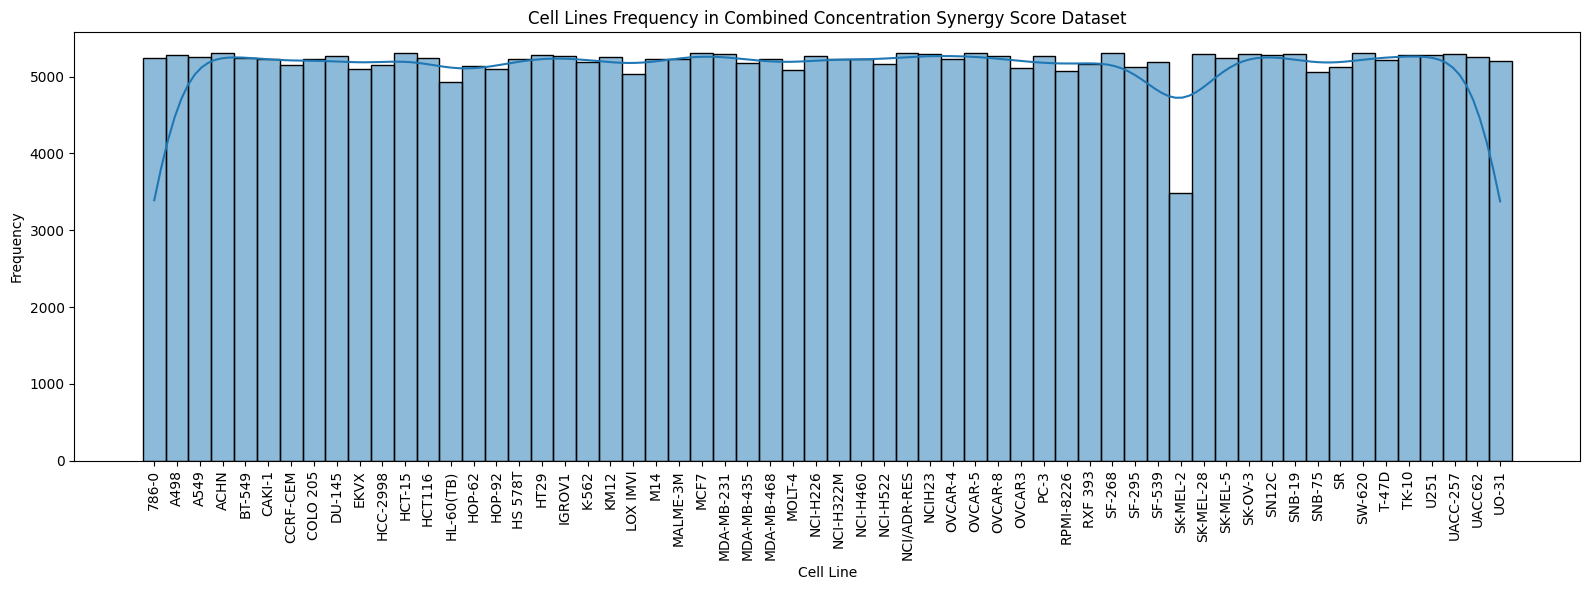

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of Cell Lines frequency in the merged_scores_df
plt.figure(figsize=(16, 6))
sns.histplot(merged_scores_df['CELLNAME'], bins=30, kde=True)
plt.title('Cell Lines Frequency in Combined Concentration Synergy Score Dataset')
plt.xlabel('Cell Line')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../figures/supplemental_cell_line_histogram_combinedconc.png')

# Print the mean, median, and standard deviation of the frequency of cell lines
cell_line_counts = merged_scores_df['CELLNAME'].value_counts()
mean_count = cell_line_counts.mean()
median_count = cell_line_counts.median()
std_count = cell_line_counts.std()
print(f'Mean count of cell lines: {mean_count}')
print(f'Median count of cell lines: {median_count}')
print(f'Standard deviation of cell lines: {std_count}')
# Print the top 5 cell lines with the highest frequency
print('Top 5 cell lines with the highest frequency:')
print(cell_line_counts.head(5))
# Print the top 5 cell lines with the lowest frequency
print('Top 5 cell lines with the lowest frequency:')
print(cell_line_counts.tail(5))

Mean count of cell lines: 47857.4
Median count of cell lines: 48322.5
Standard deviation of cell lines: 2198.005993113465
Top 5 cell lines with the highest frequency:
CELLNAME
ACHN       49026
SW-620     49026
MCF7       48999
OVCAR-5    48975
HCT-15     48948
Name: count, dtype: int64
Top 5 cell lines with the lowest frequency:
CELLNAME
HOP-92       46716
LOX IMVI     46263
EKVX         45852
HL-60(TB)    45399
SK-MEL-2     32325
Name: count, dtype: int64


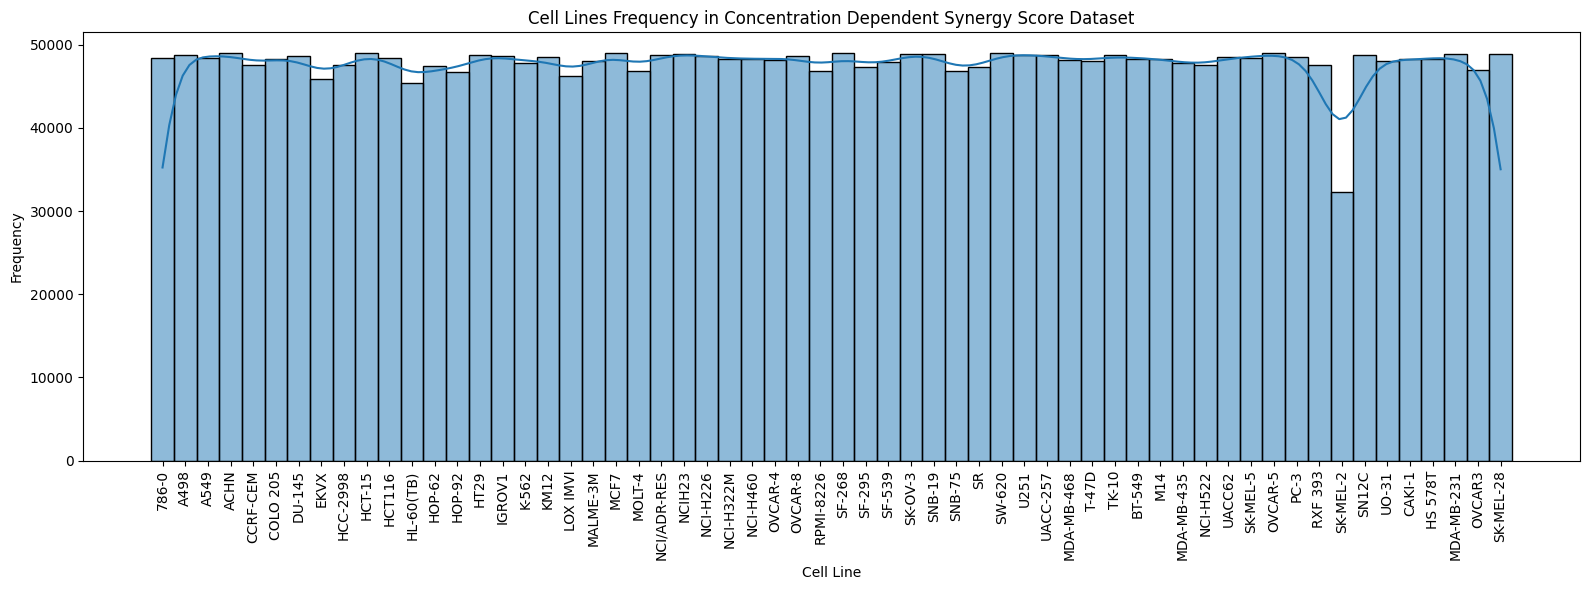

In [40]:
# Histogram of Cell Lines frequency in the merged_scores_df
plt.figure(figsize=(16, 6))
sns.histplot(almanac_concentrations_df['CELLNAME'], bins=30, kde=True)
plt.title('Cell Lines Frequency in Concentration Dependent Synergy Score Dataset')
plt.xlabel('Cell Line')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../figures/supplemental_cell_line_histogram_conc.png')

# Print the mean, median, and standard deviation of the frequency of cell lines
cell_line_counts = almanac_concentrations_df['CELLNAME'].value_counts()
mean_count = cell_line_counts.mean()
median_count = cell_line_counts.median()
std_count = cell_line_counts.std()
print(f'Mean count of cell lines: {mean_count}')
print(f'Median count of cell lines: {median_count}')
print(f'Standard deviation of cell lines: {std_count}')
# Print the top 5 cell lines with the highest frequency
print('Top 5 cell lines with the highest frequency:')
print(cell_line_counts.head(5))
# Print the top 5 cell lines with the lowest frequency
print('Top 5 cell lines with the lowest frequency:')
print(cell_line_counts.tail(5))

Mapping of drug names to NSC IDs:
  vemurafenib: Multiple NSC IDs [761431, 753082]

Counts for drugs with multiple NSC IDs:
  vemurafenib - NSC 761431: 596 occurrences
  vemurafenib - NSC 753082: 7019 occurrences
  TOTAL for vemurafenib: 7615 occurrences

Mean count of drugs: 5989.7307692307695
Median count of drugs: 5983.0
Standard deviation of drugs: 665.7810397048496
Top 5 drugs with the highest frequency:
                    Drug_Name  Count
97                 crizotinib   7623
100               vemurafenib   7615
85   raloxifene hydrochloride   6678
92                anastrozole   6549
99                 vandetanib   6509
Top 5 drugs with the lowest frequency:
                         Drug_Name  Count
101              eribulin mesylate    112
10             triethylenemelamine   5230
64                      bortezomib   5330
41       doxorubicin hydrochloride   5393
68   estramustine phosphate sodium   5532


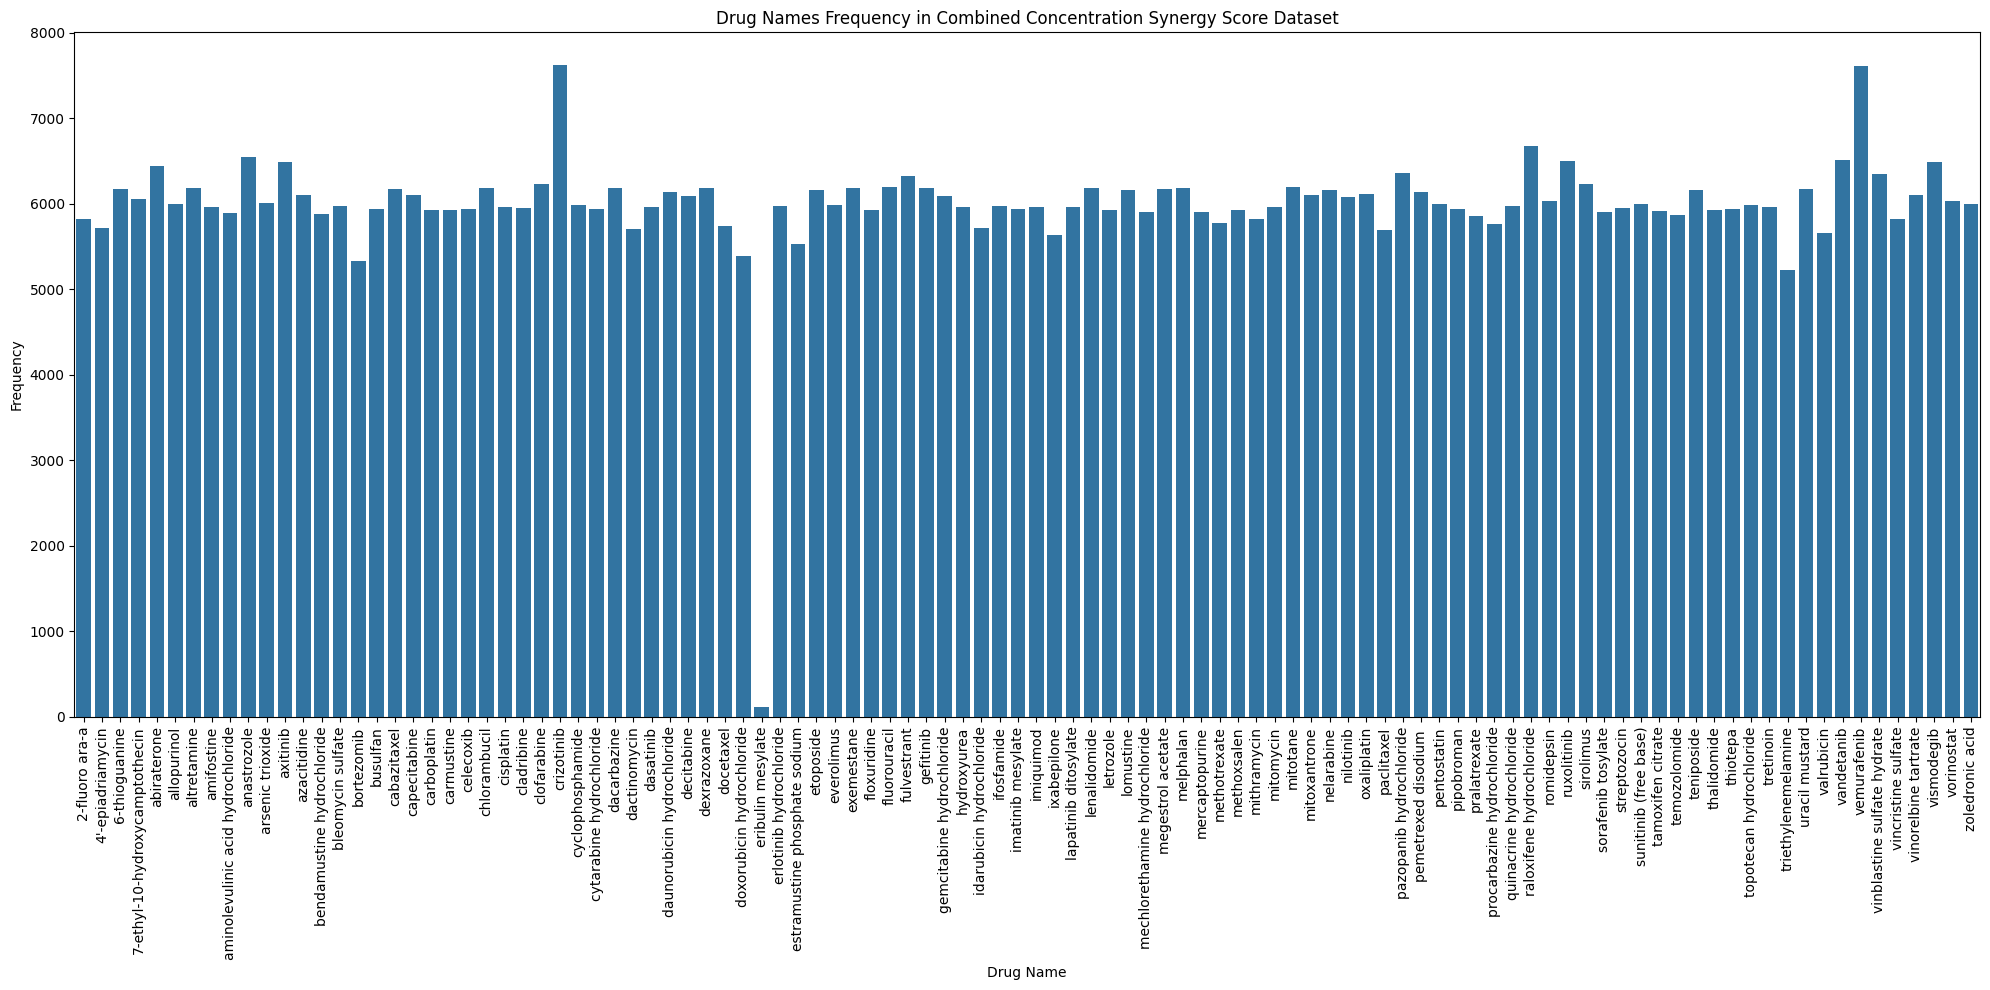

In [50]:
# For each unique drug in the merged_scores_df, add the number of times it appears in the dataset
unique_drugs_merged = set(merged_scores_df['NSC1']).union(set(merged_scores_df['NSC2']))
nsc_to_drug_name = {}
with open('../data/NCI-ALMANAC/ComboCompoundNames_small.txt') as f:
    for line in f:
        entries = line.split('\t')
        nsc_to_drug_name[int(entries[0])] = entries[1].strip('\n').lower()

# Check if multiple NSC IDs map to the same drug name
drug_name_to_nscs = {}
for nsc, drug_name in nsc_to_drug_name.items():
    if drug_name in drug_name_to_nscs:
        drug_name_to_nscs[drug_name].append(nsc)
    else:
        drug_name_to_nscs[drug_name] = [nsc]

# Print all drug names and their associated NSC IDs
print("Mapping of drug names to NSC IDs:")
for drug_name, nscs in sorted(drug_name_to_nscs.items()):
    if len(nscs) > 1:
        print(f"  {drug_name}: Multiple NSC IDs {nscs}")

# Initialize counts for each drug
drug_name_to_counts = {drug_name: 0 for drug_name in drug_name_to_nscs.keys()}

# Count occurrences for each NSC ID and add to the corresponding drug name
for drug in unique_drugs_merged:
    drug_name = nsc_to_drug_name[drug]
    drug_count = len(merged_scores_df[(merged_scores_df['NSC1'] == drug) | (merged_scores_df['NSC2'] == drug)])
    drug_name_to_counts[drug_name] += drug_count

# Print counts for drugs with multiple NSC IDs
print("\nCounts for drugs with multiple NSC IDs:")
for drug_name, nscs in drug_name_to_nscs.items():
    if len(nscs) > 1:
        # Print individual NSC counts
        total_count = 0
        for nsc in nscs:
            nsc_count = len(merged_scores_df[(merged_scores_df['NSC1'] == nsc) | (merged_scores_df['NSC2'] == nsc)])
            print(f"  {drug_name} - NSC {nsc}: {nsc_count} occurrences")
            total_count += nsc_count
        # Print combined count
        print(f"  TOTAL for {drug_name}: {total_count} occurrences\n")

# Convert dictionary to DataFrame
drug_counts_df = pd.DataFrame({
    'Drug_Name': list(drug_name_to_counts.keys()),
    'Count': list(drug_name_to_counts.values())
})

# Sort alphabetically by drug name
drug_counts_df = drug_counts_df.sort_values('Drug_Name')

# Create the plot
plt.figure(figsize=(20, 10))
sns.barplot(x='Drug_Name', y='Count', data=drug_counts_df)
plt.title('Drug Names Frequency in Combined Concentration Synergy Score Dataset')
plt.xlabel('Drug Name')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../figures/supplemental_drug_histogram_combinedconc.png')

# Print the mean, median, and standard deviation of the frequency of drugs
mean_count = drug_counts_df['Count'].mean()
median_count = drug_counts_df['Count'].median()
std_count = drug_counts_df['Count'].std()
print(f'Mean count of drugs: {mean_count}')
print(f'Median count of drugs: {median_count}')
print(f'Standard deviation of drugs: {std_count}')
# Print the top 5 drugs with the highest frequency
print('Top 5 drugs with the highest frequency:')
print(drug_counts_df.sort_values('Count', ascending=False).head(5))
# Print the top 5 drugs with the lowest frequency
print('Top 5 drugs with the lowest frequency:')
print(drug_counts_df.sort_values('Count', ascending=True).head(5))

Mean count of drugs: 55220.07692307692
Median count of drugs: 54598.5
Standard deviation of drugs: 7352.095208523245
Top 5 drugs with the highest frequency:
                    Drug_Name  Count
89   idarubicin hydrochloride  85740
90           4'-epiadriamycin  85740
97                 crizotinib  69291
100               vemurafenib  68535
85   raloxifene hydrochloride  60780
Top 5 drugs with the lowest frequency:
                         Drug_Name  Count
101              eribulin mesylate   1680
10             triethylenemelamine  47724
64                      bortezomib  48954
41       doxorubicin hydrochloride  49221
68   estramustine phosphate sodium  50460


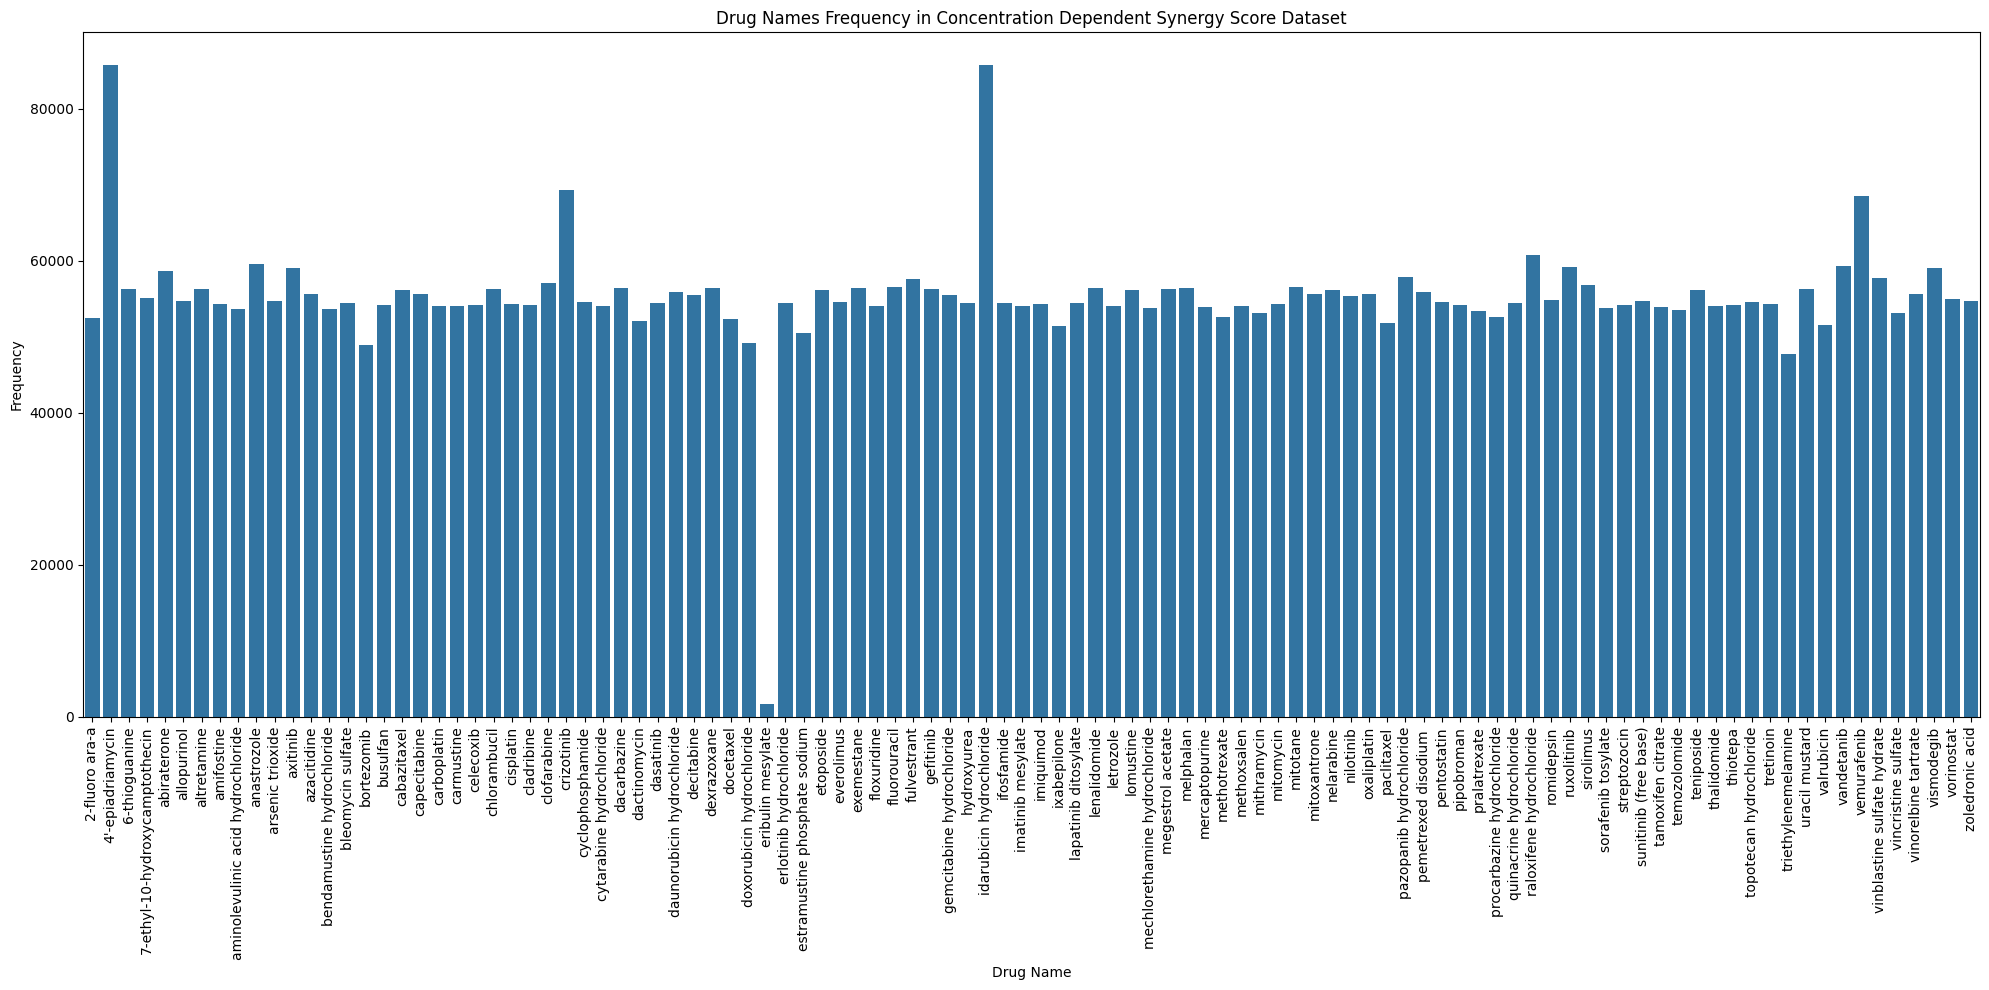

In [51]:
# For each unique drug in the almanac_concentrations_df, add the number of times it appears in the dataset
unique_drugs_almanac = set(almanac_concentrations_df['NSC1']).union(set(almanac_concentrations_df['NSC2']))
# Initialize counts for each drug
drug_name_to_counts_almanac = {drug_name: 0 for drug_name in drug_name_to_nscs.keys()}
# Count occurrences for each NSC ID and add to the corresponding drug name
for drug in unique_drugs_almanac:
    drug_name = nsc_to_drug_name[drug]
    drug_count = len(almanac_concentrations_df[(almanac_concentrations_df['NSC1'] == drug) | (almanac_concentrations_df['NSC2'] == drug)])
    drug_name_to_counts_almanac[drug_name] += drug_count
# Convert dictionary to DataFrame
drug_counts_df_almanac = pd.DataFrame({
    'Drug_Name': list(drug_name_to_counts_almanac.keys()),
    'Count': list(drug_name_to_counts_almanac.values())
})
# Sort alphabetically by drug name
drug_counts_df_almanac = drug_counts_df_almanac.sort_values('Drug_Name')
# Create the plot
plt.figure(figsize=(20, 10))
sns.barplot(x='Drug_Name', y='Count', data=drug_counts_df_almanac)
plt.title('Drug Names Frequency in Concentration Dependent Synergy Score Dataset')
plt.xlabel('Drug Name')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../figures/supplemental_drug_histogram_conc.png')
# Print the mean, median, and standard deviation of the frequency of drugs
mean_count = drug_counts_df_almanac['Count'].mean()
median_count = drug_counts_df_almanac['Count'].median()
std_count = drug_counts_df_almanac['Count'].std()
print(f'Mean count of drugs: {mean_count}')
print(f'Median count of drugs: {median_count}')
print(f'Standard deviation of drugs: {std_count}')
# Print the top 5 drugs with the highest frequency
print('Top 5 drugs with the highest frequency:')
print(drug_counts_df_almanac.sort_values('Count', ascending=False).head(5))
# Print the top 5 drugs with the lowest frequency
print('Top 5 drugs with the lowest frequency:')
print(drug_counts_df_almanac.sort_values('Count', ascending=True).head(5))
